In [11]:
# import basic libraries
import pickle
import yt
import numpy as np
import matplotlib.pyplot as plt
from math import log, log10, pi
from astropy import units as u

# import halo catalogue func
from yt.analysis_modules.halo_analysis.api import *

In [12]:
# import libraries - not sure what they do
# used to ensure halo catalog loads properly
import tempfile
import shutil
import os

# Create temporary directory for storing files
tmpdir = tempfile.mkdtemp()

In [3]:
# load halo dataset
halos_ds = yt.load('./LG4_2048_40pc/rd0070/halo_catalogs/catalog/catalog0070_thres160.0.h5')

# load raw dataset
ds = yt.load('~/../../tigress/cen/LG4_2048_40pc/RD0070/redshift0070')

# Instantiate a catalog using those two paramter files
hc = HaloCatalog(halos_ds=halos_ds, output_dir=os.path.join(tmpdir, 'halo_catalog'))
hc.load()

yt : [INFO     ] 2017-07-25 11:47:01,436 Parameters: current_time              = 3.75573046409e+16
yt : [INFO     ] 2017-07-25 11:47:01,436 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-07-25 11:47:01,438 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-07-25 11:47:01,439 Parameters: domain_right_edge         = [  2.22535525e+25   2.22535525e+25   2.22535525e+25]
yt : [INFO     ] 2017-07-25 11:47:01,440 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-07-25 11:47:01,441 Parameters: current_redshift          = 4.99999998323
yt : [INFO     ] 2017-07-25 11:47:01,442 Parameters: omega_lambda              = 0.712
yt : [INFO     ] 2017-07-25 11:47:01,443 Parameters: omega_matter              = 0.288
yt : [INFO     ] 2017-07-25 11:47:01,443 Parameters: hubble_constant           = 0.6933
yt : [INFO     ] 2017-07-25 11:47:01,638 Parameters: current_time              = 158.01757996843
yt : [INFO     ] 2017-07-25 11:47:01,642 Param

In [13]:
redshift_filename = './LG4_2048_40pc/rd0070/redshift0070'

# load redshift and Omega values from parameter file
with open(redshift_filename, 'rt') as param_file:
    param_contents = param_file.read()
    
    #redshift
    cindex1 = param_contents.find('CosmologyCurrentRedshift')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    redshift = float(param_contents[cindex_eq+2:cindex2])
    
    # omega_m
    cindex1 = param_contents.find('CosmologyOmegaMatterNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    omega_m = float(param_contents[cindex_eq+2:cindex2])
    
    # hubble const now
    cindex1 = param_contents.find('CosmologyHubbleConstantNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    hubb_now = float(param_contents[cindex_eq+2:cindex2]) *(u.km / u.s / u.Mpc) 
    
    # cosmological constant
    cindex1 = param_contents.find('CosmologyOmegaLambdaNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    cos_const = float(param_contents[cindex_eq+2:cindex2])
    
    # omega baryon as specified by Renyue
    omega_b = 0.048
    
    # box size
    cindex1 = param_contents.find('CosmologyComovingBoxSize')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    box_size = float(param_contents[cindex_eq+2:cindex2]) * u.Mpc
    
    # left edge strings
    cindex1 = param_contents.find('RefineRegionLeftEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    left_edge_string = param_contents[cindex_eq+2:cindex2]
    left_edges = left_edge_string.split()
    
    # right edge strings
    cindex1 = param_contents.find('RefineRegionRightEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    right_edge_string = param_contents[cindex_eq+2:cindex2]
    right_edges = right_edge_string.split()
    
# calculate hubble const for simulation
hubb_z = (100* hubb_now.to('s**-1')) * ((omega_m * (1 + redshift)**3) + (1 - omega_m))**0.5

# calculate crit density and threshold
GRAV_CONST = (6.67408e-11 * u.m**3 /(u.kg * u.s**2)).to('cm^3*g^-1*s^-2')
crit_dens = (3 * hubb_z**2) / (8 * pi * GRAV_CONST)
omegas = (1 - (omega_b / omega_m))
threshold = 200 * omegas * crit_dens

# min and max bounds for radial profile
# min = 1 kpc proper
# max = 0.5 Mpc comoving
# convert to centimeters value (without astropy units)
rad_min = 1 * u.kpc
rad_max = 0.5 * u.Mpc
rad_max = rad_max / (1 + redshift) # convert to physical

# specify boundaries of zoom-in box
# scaling factor multiplied by info from text file 
# units in cm
scaling =  ((box_size / hubb_now.value) / (1 + redshift)).to('kpc') # size of box
xmin = scaling*float(left_edges[0])
ymin = scaling*float(left_edges[1])
zmin = scaling*float(left_edges[2])
xmax = scaling*float(right_edges[0])
ymax = scaling*float(right_edges[1])
zmax = scaling*float(right_edges[2])

In [99]:
# --load ratio of stellar mass to halo mass
# first list uses first output of TotalMass funct
# second list uses second output

with open('./LG4_2048_40pc/rd0070/ratio_list0070_1.txt', 'rb') as ratiofile1:
    ratiolist1 = pickle.load(ratiofile1)
    
with open('./LG4_2048_40pc/rd0070/ratio_list0070_2.txt', 'rb') as ratiofile2:
    ratiolist2 = pickle.load(ratiofile2)
    
# load master calc list for LG35
with open('./master_calc0030', 'rb') as infile:
    halo_list = pickle.load(infile)

In [28]:
halo_list

[[4,
  4967,
  <Quantity 2730.2707368225533 kpc>,
  <Quantity 2747.750120971941 kpc>,
  <Quantity 2568.162295261254 kpc>,
  <Quantity 17621762811.334885 solMass>,
  <Quantity 13853352350.914053 solMass>,
  <Quantity 10.210570638324075 kpc>,
  <Quantity 22.09330767810782 kpc>,
  370,
  0,
  0,
  0,
  0,
  0],
 [7,
  4966,
  <Quantity 2812.5180462510234 kpc>,
  <Quantity 2848.2499824452275 kpc>,
  <Quantity 2664.8139402915654 kpc>,
  <Quantity 8702273964.894407 solMass>,
  <Quantity 8096654227.7456045 solMass>,
  <Quantity 8.070698947815933 kpc>,
  <Quantity 14.412224034413647 kpc>,
  1213,
  0,
  0,
  0,
  0,
  0],
 [10,
  4965,
  <Quantity 2979.6033034574075 kpc>,
  <Quantity 2406.291726076471 kpc>,
  <Quantity 2929.8603103096616 kpc>,
  <Quantity 8934947593.897242 solMass>,
  <Quantity 7299293197.986081 solMass>,
  <Quantity 8.14199629214509 kpc>,
  <Quantity 12.414740331582161 kpc>,
  2047,
  0,
  0,
  0,
  0,
  0],
 [11,
  4963,
  <Quantity 2910.375991406636 kpc>,
  <Quantity 2976.9

In [100]:
min_mass = 1e10 * u.Msun
mindex = 0

toSkip = (697, 825, 902, 914, 1111, 1211, 556)

count_zero = 0
for halo in halo_list:
    mass = halo[5]
    rad = halo[7]
    ave_age = halo[12]
    
    if ave_age ==0:
        count_zero +=1
    
    

mindex, min_mass, count_zero, len(halo_list)

(0, <Quantity 10000000000.0 solMass>, 11585, 11585)

In [ ]:
# create new ratio lists
# < 3e7 Msun, < 3e8 Msun, > 3e8 Msun
# masks used to limit Msun to 3e7-3e8, 3e8-3e9
new_ratiolist11 = []
new_ratiolist12 = []
new_ratiolist13 = []
new_ratiolist21 = []
new_ratiolist22 = []
new_ratiolist23 = []
ave_agelist1 = []
ave_agelist2 = []
ave_agelist3 = []
proxlist1 = []
proxlist2 = []
proxlist3 = []
mask1 = []
mask2 = []

for halo in halo_list:
    # find parameters of halo
    x = halo[2]
    y = halo[3]
    z = halo[4]
    center = [(x/scaling).value, (y/scaling).value, (z/scaling).value]
    halo_mass = halo[5] # new mass
    radius = halo[7] # new radius
    isSatellite = halo[9]
    gas_mass = halo[10]
    stellar_mass = halo[11]
    ave_age = halo[12]
    prox = halo[13]
    
    print(halo_mass, stellar_mass2, ave_age)

    # check that not a satellite 
    if isSatellite >= 0:
        print('IsSat')
        continue
    
#     # create a sphere data object with halo position and radius
#     sp = ds.sphere(center, (radius.to('cm').value, 'cm'))

#     # find the two output masses from TotalMass in Msun
#     masses = sp.quantities.total_mass()
#     gas_mass = masses[0] * u.g
#     particle_mass = masses[1] * u.g
#     gas_mass = gas_mass.to('Msun')
#     particle_mass = particle_mass.to('Msun')

#     # find stellar mass using total particle mass from TotalMass
#     stellar_mass = particle_mass.to('Msun') - (halo_mass*omegas).to('Msun')

    # create bools for simplification
    isAgeZero = (ave_age == 0)
    isStelMassZero = (stellar_mass == 0)
    
    # find the ratios
    if not isStelMassZero:
        ratio1 = gas_mass.to('Msun') / halo_mass.to('Msun')
        ratio2 = stellar_mass.to('Msun') / halo_mass.to('Msun')
    else:
        ratio1 = 5e-4
        ratio2 = 5e-7
    
    print(ratio1, ratio2)
    print(isAgeZero, isStelMassZero)
    
    # append differently depending on ave_age == 0
    if isAgeZero and (not isStelMassZero):
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(11)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(ratio2)
            ave_agelist1.append(0)
            proxlist1.append(prox)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(12)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(ratio2)
            ave_agelist2.append(0)
            proxlist2.append(prox)
        if halo_mass > 3e9 * u.Msun:
            print(13)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(ratio2)
            ave_agelist3.append(0)
            proxlist3.append(prox)
    if isAgeZero and isStelMassZero:
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(21)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(5e-7)
            ave_agelist1.append(0)
            proxlist1.append(prox)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(22)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(5e-7)
            ave_agelist2.append(0)
            proxlist2.append(prox)
        if halo_mass > 3e9 * u.Msun:
            print(23)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(5e-7)
            ave_agelist3.append(0)
            proxlist3.append(prox)
    if (not isAgeZero) and isStelMassZero:
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(31)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(5e-7)
            ave_agelist1.append(ave_age.to('Myr').value)
            proxlist1.append(prox)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(32)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(5e-7)
            ave_agelist2.append(ave_age.to('Myr').value)
            proxlist2.append(prox)
        if halo_mass > 3e9 * u.Msun:
            print(33)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(5e-7)
            ave_agelist3.append(ave_age.to('Myr').value)
            proxlist3.append(prox)
    if (not isAgeZero) and (not isStelMassZero):
        # add ratios to their own lists
        if 3e8 * u.Msun > halo_mass > 3e7 * u.Msun:
            print(4)
            new_ratiolist11.append(ratio1)
            new_ratiolist21.append(ratio2.value)
            ave_agelist1.append(ave_age.to('Myr').value)
            proxlist1.append(prox)
        if 3e9 * u.Msun > halo_mass > 3e8 * u.Msun:
            print(5)
            new_ratiolist12.append(ratio1)
            new_ratiolist22.append(ratio2.value)
            ave_agelist2.append(ave_age.to('Myr').value)
            proxlist2.append(prox)
        if halo_mass > 3e9 * u.Msun:
            print(6)
            new_ratiolist13.append(ratio1)
            new_ratiolist23.append(ratio2.value)
            ave_agelist3.append(ave_age.to('Myr').value)
            proxlist3.append(prox)

9060402645.837389 solMass 0 0
0.0005 5e-07
True True
23
7849008048.218473 solMass 0 0
0.0005 5e-07
True True
23
7399207108.754084 solMass 0 0
0.0005 5e-07
True True
23
6012712815.028287 solMass 0 0
0.0005 5e-07
True True
23
5308698775.584763 solMass 0 0
0.0005 5e-07
True True
23
5091044155.85847 solMass 0 0
0.0005 5e-07
True True
23
4602954228.913103 solMass 0 0
0.0005 5e-07
True True
23
3811687379.60136 solMass 0 0
0.0005 5e-07
True True
23
4450990193.589116 solMass 0 0
0.0005 5e-07
True True
23
3948361569.5120573 solMass 0 0
0.0005 5e-07
True True
23
3380693047.0487437 solMass 0 0
0.0005 5e-07
True True
23
4171191837.3055587 solMass 0 0
0.0005 5e-07
True True
23
4163167573.2612658 solMass 0 0
0.0005 5e-07
True True
23
4127125683.0258884 solMass 0 0
0.0005 5e-07
True True
23
3311580061.7761135 solMass 0 0
0.0005 5e-07
True True
23
3851504207.974008 solMass 0 0
0.0005 5e-07
True True
23
3103117608.449036 solMass 0 0
0.0005 5e-07
True True
23
2751890532.9183197 solMass 0 0
0.0005 5e-07


588811478.9630964 solMass 0 0
0.0005 5e-07
True True
22
456116096.6460074 solMass 0 0
0.0005 5e-07
True True
22
537578493.6529027 solMass 0 0
0.0005 5e-07
True True
22
560286451.0981317 solMass 0 0
0.0005 5e-07
True True
22
555998939.4173287 solMass 0 0
0.0005 5e-07
True True
22
689095607.5259045 solMass 0 0
0.0005 5e-07
True True
22
592061139.5942394 solMass 0 0
0.0005 5e-07
True True
22
538771497.5146989 solMass 0 0
0.0005 5e-07
True True
22
544813288.6260415 solMass 0 0
0.0005 5e-07
True True
22
349758399.32044846 solMass 0 0
0.0005 5e-07
True True
22
570877774.2413312 solMass 0 0
0.0005 5e-07
True True
22
524620713.9892916 solMass 0 0
0.0005 5e-07
True True
22
505075687.0924512 solMass 0 0
0.0005 5e-07
True True
22
485822910.0439542 solMass 0 0
0.0005 5e-07
True True
22
477872341.48642 solMass 0 0
0.0005 5e-07
True True
22
509706457.7961231 solMass 0 0
0.0005 5e-07
True True
22
484825300.77280396 solMass 0 0
0.0005 5e-07
True True
22
454069210.4914255 solMass 0 0
0.0005 5e-07
True 

258461768.13549015 solMass 0 0
0.0005 5e-07
True True
21
278987651.0028123 solMass 0 0
0.0005 5e-07
True True
21
256725826.88035333 solMass 0 0
0.0005 5e-07
True True
21
204831553.80231428 solMass 0 0
0.0005 5e-07
True True
21
279709866.4291911 solMass 0 0
0.0005 5e-07
True True
21
237743285.98409247 solMass 0 0
0.0005 5e-07
True True
21
319327632.4365659 solMass 0 0
0.0005 5e-07
True True
22
222737595.2789142 solMass 0 0
0.0005 5e-07
True True
21
222337281.22663188 solMass 0 0
0.0005 5e-07
True True
21
226751737.31490192 solMass 0 0
0.0005 5e-07
True True
21
272280955.2044102 solMass 0 0
0.0005 5e-07
True True
21
228511447.21707928 solMass 0 0
0.0005 5e-07
True True
21
294629048.73529947 solMass 0 0
0.0005 5e-07
True True
21
222666029.3570686 solMass 0 0
0.0005 5e-07
True True
21
328293501.1231426 solMass 0 0
0.0005 5e-07
True True
22
141652401.1950268 solMass 0 0
0.0005 5e-07
True True
21
272645918.36498904 solMass 0 0
0.0005 5e-07
True True
21
315361263.4404104 solMass 0 0
0.0005 5e

0.0005 5e-07
True True
21
136286435.0285118 solMass 0 0
0.0005 5e-07
True True
21
97841103.3273395 solMass 0 0
0.0005 5e-07
True True
21
112091238.14285271 solMass 0 0
0.0005 5e-07
True True
21
130438957.79572755 solMass 0 0
0.0005 5e-07
True True
21
121066177.72938813 solMass 0 0
0.0005 5e-07
True True
21
126324468.8179161 solMass 0 0
0.0005 5e-07
True True
21
188752542.7403292 solMass 0 0
0.0005 5e-07
True True
21
106940408.76944447 solMass 0 0
0.0005 5e-07
True True
21
132732272.3247147 solMass 0 0
0.0005 5e-07
True True
21
83469904.02957726 solMass 0 0
0.0005 5e-07
True True
21
135406795.92828903 solMass 0 0
0.0005 5e-07
True True
21
126969212.50235546 solMass 0 0
0.0005 5e-07
True True
21
193595231.96979043 solMass 0 0
0.0005 5e-07
True True
21
119854775.12269479 solMass 0 0
0.0005 5e-07
True True
21
156314197.49159604 solMass 0 0
0.0005 5e-07
True True
21
157239750.78452578 solMass 0 0
0.0005 5e-07
True True
21
141010556.0024432 solMass 0 0
0.0005 5e-07
True True
21
149307058.834

110162421.28467287 solMass 0 0
0.0005 5e-07
True True
21
116710471.09114374 solMass 0 0
0.0005 5e-07
True True
21
118957794.50088812 solMass 0 0
0.0005 5e-07
True True
21
112927081.16013879 solMass 0 0
0.0005 5e-07
True True
21
86080141.56217092 solMass 0 0
0.0005 5e-07
True True
21
95992705.80635771 solMass 0 0
0.0005 5e-07
True True
21
69392060.47292674 solMass 0 0
0.0005 5e-07
True True
21
106163672.82948259 solMass 0 0
0.0005 5e-07
True True
21
93952928.41966599 solMass 0 0
0.0005 5e-07
True True
21
138411113.0000047 solMass 0 0
0.0005 5e-07
True True
21
127092988.43908782 solMass 0 0
0.0005 5e-07
True True
21
83349172.90568134 solMass 0 0
0.0005 5e-07
True True
21
80529587.65829523 solMass 0 0
0.0005 5e-07
True True
21
118945878.32273301 solMass 0 0
0.0005 5e-07
True True
21
115537772.94280607 solMass 0 0
0.0005 5e-07
True True
21
153472921.54811704 solMass 0 0
0.0005 5e-07
True True
21
81160879.03785363 solMass 0 0
0.0005 5e-07
True True
21
81184010.52933244 solMass 0 0
0.0005 5e

True True
21
71906504.14037131 solMass 0 0
0.0005 5e-07
True True
21
76393802.11251234 solMass 0 0
IsSat
57302164.24226083 solMass 0 0
0.0005 5e-07
True True
21
93775000.66174257 solMass 0 0
0.0005 5e-07
True True
21
104792462.65437673 solMass 0 0
0.0005 5e-07
True True
21
102353207.31152843 solMass 0 0
0.0005 5e-07
True True
21
112634690.80818595 solMass 0 0
0.0005 5e-07
True True
21
89216206.87900215 solMass 0 0
0.0005 5e-07
True True
21
51619130.227166556 solMass 0 0
0.0005 5e-07
True True
21
91064123.724136 solMass 0 0
0.0005 5e-07
True True
21
131375790.80698463 solMass 0 0
0.0005 5e-07
True True
21
81272702.40579969 solMass 0 0
0.0005 5e-07
True True
21
131210131.81229237 solMass 0 0
0.0005 5e-07
True True
21
57872407.2757825 solMass 0 0
0.0005 5e-07
True True
21
111725992.16435234 solMass 0 0
0.0005 5e-07
True True
21
72764154.56808184 solMass 0 0
0.0005 5e-07
True True
21
83493463.18301587 solMass 0 0
0.0005 5e-07
True True
21
84104990.4297106 solMass 0 0
0.0005 5e-07
True True

0.0005 5e-07
True True
21
101930843.00804126 solMass 0 0
0.0005 5e-07
True True
21
83944602.20585512 solMass 0 0
0.0005 5e-07
True True
21
85417058.46543032 solMass 0 0
0.0005 5e-07
True True
21
142431009.2868873 solMass 0 0
0.0005 5e-07
True True
21
56209679.73310002 solMass 0 0
0.0005 5e-07
True True
21
55179882.53620361 solMass 0 0
0.0005 5e-07
True True
21
76440994.36313419 solMass 0 0
0.0005 5e-07
True True
21
47309600.29563246 solMass 0 0
0.0005 5e-07
True True
21
69046485.59565045 solMass 0 0
0.0005 5e-07
True True
21
55238804.23690985 solMass 0 0
0.0005 5e-07
True True
21
34064278.30995391 solMass 0 0
0.0005 5e-07
True True
21
54519796.94570023 solMass 0 0
0.0005 5e-07
True True
21
56606903.14382533 solMass 0 0
0.0005 5e-07
True True
21
53475381.24745808 solMass 0 0
0.0005 5e-07
True True
21
52021794.85806359 solMass 0 0
IsSat
72212424.43597233 solMass 0 0
0.0005 5e-07
True True
21
65748872.62381449 solMass 0 0
0.0005 5e-07
True True
21
58498389.80057159 solMass 0 0
0.0005 5e-0

56960879.784786195 solMass 0 0
0.0005 5e-07
True True
21
42562398.07523939 solMass 0 0
0.0005 5e-07
True True
21
65078075.02785479 solMass 0 0
0.0005 5e-07
True True
21
42704696.667888515 solMass 0 0
0.0005 5e-07
True True
21
25950311.785642833 solMass 0 0
0.0005 5e-07
True True
60847680.667750046 solMass 0 0
0.0005 5e-07
True True
21
54507732.937563114 solMass 0 0
0.0005 5e-07
True True
21
101420895.96748194 solMass 0 0
0.0005 5e-07
True True
21
98167964.55468391 solMass 0 0
0.0005 5e-07
True True
21
47115747.72432981 solMass 0 0
0.0005 5e-07
True True
21
56841905.51936606 solMass 0 0
0.0005 5e-07
True True
21
43681250.57742053 solMass 0 0
0.0005 5e-07
True True
21
60119508.40064315 solMass 0 0
0.0005 5e-07
True True
21
46491470.42814608 solMass 0 0
0.0005 5e-07
True True
21
58286660.57897723 solMass 0 0
0.0005 5e-07
True True
21
68019974.1189192 solMass 0 0
0.0005 5e-07
True True
21
62133565.23988416 solMass 0 0
0.0005 5e-07
True True
21
106016105.8082372 solMass 0 0
0.0005 5e-07
Tru

True True
36212624.783360064 solMass 0 0
0.0005 5e-07
True True
21
48034310.735688075 solMass 0 0
0.0005 5e-07
True True
21
38790149.68571746 solMass 0 0
0.0005 5e-07
True True
21
24190199.864800233 solMass 0 0
0.0005 5e-07
True True
60999518.85810659 solMass 0 0
0.0005 5e-07
True True
21
46262628.09434091 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
44674631.16608189 solMass 0 0
0.0005 5e-07
True True
21
48689448.268286616 solMass 0 0
0.0005 5e-07
True True
21
37527540.04116149 solMass 0 0
0.0005 5e-07
True True
21
74406326.62850463 solMass 0 0
0.0005 5e-07
True True
21
76399562.96548547 solMass 0 0
0.0005 5e-07
True True
21
50496877.8733956 solMass 0 0
0.0005 5e-07
True True
21
63690028.12950091 solMass 0 0
0.0005 5e-07
True True
21
32806027.35858738 solMass 0 0
0.0005 5e-07
True True
21
44843355.735171504 solMass 0 0
0.0005 5e-07
True True
21
26754018.19125364 solMass 0 0
0.0005 5e-07
True True
32610901.785047438 solMass 0 0
0.0005 5e-07
True True
21


41569331.16352804 solMass 0 0
0.0005 5e-07
True True
21
32541946.057228234 solMass 0 0
0.0005 5e-07
True True
21
31750994.48967651 solMass 0 0
0.0005 5e-07
True True
21
23845165.154197462 solMass 0 0
0.0005 5e-07
True True
42492069.17793822 solMass 0 0
0.0005 5e-07
True True
21
28842670.9606954 solMass 0 0
0.0005 5e-07
True True
82909758.46329688 solMass 0 0
0.0005 5e-07
True True
21
33411150.27673693 solMass 0 0
0.0005 5e-07
True True
21
23488982.77255578 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
25849722.00592116 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
45572907.406181075 solMass 0 0
0.0005 5e-07
True True
21
42601882.475555226 solMass 0 0
0.0005 5e-07
True True
21
38903566.19541786 solMass 0 0
0.0005 5e-07
True True
21
40568170.05460711 solMass 0 0
0.0005 5e-07
True True
21
36638397.5884182 solMass 0 0
0.0005 5e-07
True True
21
39474414.16621

0.0 solMass 0 0
0.0005 5e-07
True True
45998027.385908 solMass 0 0
0.0005 5e-07
True True
21
28260007.208264403 solMass 0 0
0.0005 5e-07
True True
25771442.242486123 solMass 0 0
0.0005 5e-07
True True
29962970.667502254 solMass 0 0
0.0005 5e-07
True True
41766703.71361975 solMass 0 0
0.0005 5e-07
True True
21
29847642.446589988 solMass 0 0
0.0005 5e-07
True True
37850387.930401914 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
56218794.04185274 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
35336215.3300725 solMass 0 0
0.0005 5e-07
True True
21
55328764.60716257 solMass 0 0
0.0005 5e-07
True True
21
47552204.16993268 solMass 0 0
0.0005 5e-07
True True
21
28515380.17328405 solMass 0 0
0.0005 5e-07
True True
36576703.302720286 solMass 0 0
0.0005 5e-07
True True
21
56142818.17814444 solMass 0 0
0.0005 5e-07
True Tr

26887393.568179253 solMass 0 0
0.0005 5e-07
True True
70046485.4230966 solMass 0 0
0.0005 5e-07
True True
21
46261409.35328145 solMass 0 0
0.0005 5e-07
True True
21
27037125.839391153 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
25706804.548602484 solMass 0 0
0.0005 5e-07
True True
28418696.460663423 solMass 0 0
0.0005 5e-07
True True
24656298.33046816 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
31391248.667897135 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
26614545.255827956 solMass 0 0
0.0005 5e-07
True True
37411937.472526215 solMass 0 0
0.0005 5e-07
True True
21
33004308.15725048 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
38806016.69739756 solMass 0 0
0.0005 5e-07
Tr

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
28605024.37530235 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
28295372.23345608 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
25162339.911793757 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
19500340.0596507 solMass 0 0
0.0005 5e-07
True True
22259796.70520328 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23016527.31283298 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0

True False
12
977677743.4728789 solMass 0 0
0.2334550540934386 0.0049090248529472
True False
12
1295707979.7144969 solMass 0 0
0.1902298621018285 0.0018482432999635152
True False
12
1328380192.542706 solMass 0 0
0.21754340548160658 0.0017021087399535185
True False
12
1560467286.2775612 solMass 0 0
0.22134339062891661 1.650937216708991e-06
True False
12
1143718173.0315504 solMass 0 0
0.1849618757015802 0.00016122495635631783
True False
12
1087028141.0074263 solMass 0 0
0.32089187291877547 0.02493465329802215
True False
12
1050167287.8432409 solMass 0 0
0.2129026129068929 0.0029089401191285864
True False
12
1011572640.5563571 solMass 0 0
0.1907156933173426 0.00043922668301293866
True False
12
1277748796.2586033 solMass 0 0
0.1722356060157943 0.0006624077495038445
True False
12
1165922258.9237375 solMass 0 0
0.21030882029299233 0.0002534118543010443
True False
12
1017737212.9832497 solMass 0 0
0.18347566225105016 0.001110492012363926
True False
12
923376115.672688 solMass 0 0
0.3001743382

429627727.1144972 solMass 0 0
0.1965934161224469 0.001545304345647378
True False
12
638505437.1123844 solMass 0 0
0.0005 5e-07
True True
22
437520824.5683231 solMass 0 0
0.19984922824543444 0.0005742482701300536
True False
12
517579932.5320427 solMass 0 0
0.0005 5e-07
True True
22
467306449.2836543 solMass 0 0
0.22356558273599658 0.007805741202506684
True False
12
468039594.3541195 solMass 0 0
0.26151559801810825 0.0035836809188137925
True False
12
421797530.4655443 solMass 0 0
0.3424680650274911 0.0008920240713745681
True False
12
341051165.8642908 solMass 0 0
0.2670999145934587 0.0005528330834409113
True False
12
373768775.2818044 solMass 0 0
0.2525092328124494 0.00046869586453530157
True False
12
471310467.8639603 solMass 0 0
0.2724843367484216 0.00038299160205379533
True False
12
456086282.1731081 solMass 0 0
0.22146537287610568 0.004444040349455307
True False
12
458016664.0248801 solMass 0 0
0.2576263331177654 0.0005568511767270656
True False
12
426642407.0796988 solMass 0 0
0.194

0.0005 5e-07
True True
21
145968219.73946705 solMass 0 0
0.6297902504435201 0.0007773145797231523
True False
11
202238509.9712314 solMass 0 0
0.0005 5e-07
True True
21
184803538.02195972 solMass 0 0
0.0005 5e-07
True True
21
208699427.82639977 solMass 0 0
0.0005 5e-07
True True
21
158491317.26469195 solMass 0 0
0.4869677081658272 0.00078738167610196
True False
11
160982605.652414 solMass 0 0
0.0005 5e-07
True True
21
213484306.3272721 solMass 0 0
0.0005 5e-07
True True
21
180891466.24486864 solMass 0 0
0.33563987351335955 0.0001709024912109125
True False
11
158198838.7214342 solMass 0 0
0.48637676663896257 6.513912590403469e-05
True False
11
136400962.66689813 solMass 0 0
0.3969440916183416 0.0008428035270342093
True False
11
167257908.1054963 solMass 0 0
0.0005 5e-07
True True
21
120810672.1513719 solMass 0 0
0.3928179785010388 0.00010662276239589816
True False
11
104460559.2845849 solMass 0 0
0.5510589912816701 0.0037955121307246677
True False
11
257892812.57143143 solMass 0 0
0.0005

95237105.16726696 solMass 0 0
0.24963860925798273 2.7050733155026086e-05
True False
11
114803499.68890214 solMass 0 0
0.0005 5e-07
True True
21
142347418.68920097 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
109220850.50345072 solMass 0 0
0.0005 5e-07
True True
21
89308057.73887374 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
103096905.7420163 solMass 0 0
0.0005 5e-07
True True
21
62606862.90065951 solMass 0 0
0.0005 5e-07
True True
21
106805908.47679275 solMass 0 0
0.0005 5e-07
True True
21
133858054.63820547 solMass 0 0
0.0005 5e-07
True True
21
78063940.66633411 solMass 0 0
0.8363708303703117 0.0015673319794374631
True False
11
80050444.00395632 solMass 0 0
0.0005 5e-07
True True
21
144291493.95776558 solMass 0 0
0.0005 5e-07
True True
21
72194906.41187003 solMass 0 0
0.0005 5e-07
True True
21
59967831.766078606 solMass 0 0
0.0005 5e-07
True True
21
65392668.45262646 solMass 0 0
0.0005 5e-07
True True
21
88957558.294973

57287257.77111212 solMass 0 0
0.0005 5e-07
True True
21
41539947.83734285 solMass 0 0
0.0005 5e-07
True True
21
99810614.72987731 solMass 0 0
0.0005 5e-07
True True
21
45020459.04806635 solMass 0 0
0.0005 5e-07
True True
21
68693322.55410995 solMass 0 0
0.0005 5e-07
True True
21
65971551.253582515 solMass 0 0
0.0005 5e-07
True True
21
48859870.32421346 solMass 0 0
0.0005 5e-07
True True
21
5718065118.439697 solMass 0 0
IsSat
57430456.98036337 solMass 0 0
0.0005 5e-07
True True
21
45430698.468661144 solMass 0 0
0.0005 5e-07
True True
21
57714113.116743475 solMass 0 0
0.0005 5e-07
True True
21
59847834.922430955 solMass 0 0
0.0005 5e-07
True True
21
68344528.3009218 solMass 0 0
0.0005 5e-07
True True
21
81249538.06071146 solMass 0 0
0.0005 5e-07
True True
21
23924986.189257648 solMass 0 0
0.0005 5e-07
True True
50905452.14214879 solMass 0 0
0.0005 5e-07
True True
21
82317601.48074135 solMass 0 0
0.0005 5e-07
True True
21
58036799.634258054 solMass 0 0
0.0005 5e-07
True True
21
70545758.3

44567396.14283864 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
23762107.535892833 solMass 0 0
0.0005 5e-07
True True
25298508.560198437 solMass 0 0
0.0005 5e-07
True True
34416758.10557976 solMass 0 0
0.0005 5e-07
True True
21
46398354.625087045 solMass 0 0
0.0005 5e-07
True True
21
73845376.90379278 solMass 0 0
0.0005 5e-07
True True
21
34686734.11414567 solMass 0 0
0.0005 5e-07
True True
21
42325264.098092474 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
36582540.80084024 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
49154279.67780815 solMass 0 0
0.0005 5e-07
True True
21
29067982.223793473 solMass 0 0
0.0005 5e-07
True True
51558528.92034814 solMass 0 0
0.0005 5e-07
True True
21
23553792.455650028 solMass 0 0
0.0005 5e-07
True True
39930713.842092104 solMass 0 0
0.0005 5e-07
True True
21
38202201.981100254 solMass 0 0
0.0005 5e-07
True True
21
51578937.62439975 solMass 0 0
0.0005 5e-07
True

True True
30897687.106517356 solMass 0 0
0.0005 5e-07
True True
21
26453474.232397493 solMass 0 0
0.0005 5e-07
True True
40736726.61199107 solMass 0 0
0.0005 5e-07
True 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27613603.09815777 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24482113.264286984 solMass 0 0
0.0005 5e-07
True True
26039420.970824096 solMass 0 0
0.0005 5e-07
True True
40367603.99841689 solMass 0 0
0.0005 5e-07
True True
21
44145169.39310523 solMass 0 0
0.0005 5e-07
True True
21
20116935.090976775 solMass 0 0
0.0005 5e-07
True True
30504411.07076279 solMass 0 0
0.0005 5e-07
True True
21
26521828.49979582 solMass 0 0
0.0005 5e-07
True True
26228407.672492255 solMass 0 0
0.0005 5e-07
True True
34547420.59234358 solMass 0 0
0.0005 5e-07
True True
21
41809394.41764925 sol

0.0005 5e-07
True True
22038582.548081957 solMass 0 0
0.0005 5e-07
True True
27308508.36959196 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
30519399.66558764 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24671186.697774034 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
20380069.321206126 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23462331.23468749 solMass 0 0
0.0005 5e-07
True True
31487223.472696822 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
6434482833.71484 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
2466175231.7327013 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
16829839567.759224 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0

IsSat
2881210275.2430077 solMass 0 0
0.19321132512014835 0.018314539041037078
True False
12
2354732449.964579 solMass 0 0
0.16670780308566227 0.0005504806531765889
True False
12
2830889231.206838 solMass 0 0
0.19734227409009047 0.006556587189441667
True False
12
2356766817.017065 solMass 0 0
IsSat
2627784980.6417365 solMass 0 0
0.17798521617172983 0.005967742427809807
True False
12
2486182230.9581075 solMass 0 0
0.18514469919880186 0.03585051786190464
True False
12
2065694671.6319792 solMass 0 0
IsSat
1996171034.650181 solMass 0 0
IsSat
1039603899.2064639 solMass 0 0
0.18437772155277402 0.0017569071536795045
True False
12
2097022239.0335073 solMass 0 0
0.18562584819444197 0.007259776724946925
True False
12
1917801029.1966822 solMass 0 0
IsSat
1664940100.8110795 solMass 0 0
0.21555064956298856 0.020490562904108143
True False
12
1710918547.1836596 solMass 0 0
0.14751362768159143 0.008120786846625318
True False
12
1612326401.3704958 solMass 0 0
0.2078020151655089 0.007817825547618245
True

148722055.25068268 solMass 0 0
0.404436235074065 0.0015289016041533455
True False
11
137258778.03802672 solMass 0 0
IsSat
169439171.8285222 solMass 0 0
0.32296429586023306 0.00033432174231702035
True False
11
108564550.86588249 solMass 0 0
0.5374282762236748 0.0013763382510593857
True False
11
127077129.13165775 solMass 0 0
0.0005 5e-07
True True
21
196773546.3184517 solMass 0 0
0.2592237495522511 1.3406079920830082e-05
True False
11
124453363.55381495 solMass 0 0
0.5845810792199687 0.013820060413242711
True False
11
200672685.46338546 solMass 0 0
0.0005 5e-07
True True
21
197713732.32498565 solMass 0 0
0.0005 5e-07
True True
21
157980696.8941511 solMass 0 0
0.0005 5e-07
True True
21
164408202.6328792 solMass 0 0
0.0005 5e-07
True True
21
77009010.89921758 solMass 0 0
0.0005 5e-07
True True
21
142885325.74293542 solMass 0 0
0.3601735376005783 0.0005949925624976866
True False
11
108839934.07165053 solMass 0 0
0.0005 5e-07
True True
21
161810079.4594141 solMass 0 0
0.32016938642132037 0.

61779059.83743461 solMass 0 0
0.0005 5e-07
True True
21
69477409.46574958 solMass 0 0
0.0005 5e-07
True True
21
71888755.83333139 solMass 0 0
0.0005 5e-07
True True
21
63426394.14669135 solMass 0 0
0.0005 5e-07
True True
21
86570323.14721589 solMass 0 0
0.0005 5e-07
True True
21
57980528.65891271 solMass 0 0
0.0005 5e-07
True True
21
84956420.88819668 solMass 0 0
0.0005 5e-07
True True
21
67235448.36679825 solMass 0 0
0.2909132944483168 0.004279321578067095
True False
11
61913341.99302358 solMass 0 0
0.4374506132830595 4.161031266390752e-05
True False
11
50660258.4771714 solMass 0 0
0.0005 5e-07
True True
21
48282343.77145885 solMass 0 0
0.0005 5e-07
True True
21
84418725.84925593 solMass 0 0
0.0005 5e-07
True True
21
82380924.24745099 solMass 0 0
0.0005 5e-07
True True
21
87459398.31991786 solMass 0 0
0.0005 5e-07
True True
21
73272864.96420343 solMass 0 0
0.0005 5e-07
True True
21
103077920.27688922 solMass 0 0
0.0005 5e-07
True True
21
55819580.389371574 solMass 0 0
0.0005 5e-07
Tru

36117960.72235257 solMass 0 0
0.0005 5e-07
True True
21
45969100.366960034 solMass 0 0
0.0005 5e-07
True True
21
26059060.804260213 solMass 0 0
0.0005 5e-07
True True
26372473.644523293 solMass 0 0
0.0005 5e-07
True True
50189055.92995116 solMass 0 0
0.7353534513428491 0.0004736963584947464
True False
11
23609607.14862531 solMass 0 0
0.0005 5e-07
True True
43146778.713888794 solMass 0 0
0.0005 5e-07
True True
21
26180426.29125655 solMass 0 0
0.0005 5e-07
True True
50327942.996162266 solMass 0 0
0.0005 5e-07
True True
21
56432068.94914078 solMass 0 0
0.0005 5e-07
True True
21
56161087.56314058 solMass 0 0
0.0005 5e-07
True True
21
31044196.524239115 solMass 0 0
0.0005 5e-07
True True
21
True True
21
32437417.138789713 solMass 0 0
0.0005 5e-07
True True
21
37492376.62025905 solMass 0 0
0.0005 5e-07
True True
21
38148605.40624053 solMass 0 0
0.0005 5e-07
True True
21
53490682.46312954 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
28486978.31021481 solMass 0 

23873588.428686548 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
24244386.352129534 solMass 0 0
0.0005 5e-07
True True
31654986.89692839 solMass 0 0
0.0005 5e-07
True True
21
31082909.13755143 solMass 0 0
0.0005 5e-07
True True
21
34719254.02065951 solMass 0 0
0.0005 5e-07
True True
21
2324113890.7764773 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
27675964.052621294 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
29629138.430221908 solMass 0 0
0.0005 5e-07
True True
31307301.369858216 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
35233835.99752911 solMass 0 0
0.0005 5e-07
True True
21
80415152.42994682 solMass 0 0
IsSat
0.0 solMass 0 0
0.0005 5e-07
True True
31410314.518422585 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
23154692.586912412 sol

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
28732601.599780165 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
28123913.26524058 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
34018916.74584395 solMass 0 0
0.0005 5e-07
True True
21
24656888.385763604 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0

0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
32318327.128548425 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
5.08544448789425e+26 solMass 0 0
3.916113701490751e-17 3.4571671009173928e-18
True False
13
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
23981283.

0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e-07
True True
0.0 solMass 0 0
0.0005 5e

2673637304.611092 solMass 0 0
0.20454214496930184 0.03824527113747758
True False
12
2889547189.496681 solMass 0 0
0.206608891262621 0.034920683727792536
True False
12
2924621748.3057218 solMass 0 0
0.2385521828817707 0.01890775541985495
True False
12
3124379589.451103 solMass 0 0
0.14109861489423517 0.01948913089482225
True False
13
2642579833.8660026 solMass 0 0
0.28516706083649423 0.0412887899727299
True False
12
2548833129.2902074 solMass 0 0
0.20493965188721533 0.019685068788921085
True False
12
2544370775.745768 solMass 0 0
0.22903244774238504 0.014989056444824986
True False
12
2681271888.795906 solMass 0 0
0.1649210133229967 0.011292349382326584
True False
12
2041284773.3521519 solMass 0 0
0.19579339760565923 0.010111801878673108
True False
12
2403720031.6491094 solMass 0 0
0.1744446681958782 0.0053454549624284975
True False
12
2317433449.046914 solMass 0 0
0.2238949868081661 0.02031502407462171
True False
12
2180187224.516478 solMass 0 0
0.17813800351781706 0.004853663178183019


True True
22
784431462.7894471 solMass 0 0
0.22736048376351115 0.0006690613975923782
True False
12
544644463.7414292 solMass 0 0
0.2766485440193868 0.004931415866897161
True False
12
678337836.4876326 solMass 0 0
0.292753881868918 0.013628432048053809
True False
12
575703406.1749648 solMass 0 0
0.225492862040862 0.003906794045631581
True False
12
600579184.3865044 solMass 0 0
0.22286802717317342 0.00021152720643091778
True False
12
582656826.8820564 solMass 0 0
0.2128587725919407 0.0030956036048229206
True False
12
614635200.6730248 solMass 0 0
0.26061749164539344 0.01095550736303353
True False
12
780489975.6007549 solMass 0 0
0.16408307831781213 0.0004979601791426613
True False
12
711892234.8614099 solMass 0 0
0.25320821076280087 0 0
0.2757903860663413 0.0012039153482556486
True False
12
354827780.627517 solMass 0 0
0.38081645711777073 0.001172596721210406
True False
12
392330741.4886008 solMass 0 0
0.26271544542842334 0.00018728600312710705
True False
12
503647864.8171685 solMass 0 0

0.3043325862267318 0.0005802836434770596
True False
11
310356476.6620757 solMass 0 0
0.1624556934088752 5.8901777417459113e-05
True False
12
252760750.72946748 solMass 0 0
0.26679378086832195 0.0011540992477085815
True False
11
250075728.42048955 solMass 0 0
0.3261831600673071 0.008543488824983817
True False
11
263124418.91550016 solMass 0 0
0.34127995294082564 0.004538116732560368
True False
11
119005985.17871313 solMass 0 0
0.0005 5e-07
True True
21
324111061.3161892 solMass 0 0
0.19185013595366385 4.140954268553555e-05
True False
12
240274396.84787294 solMass 0 0
0.23718030476621943 0.0006326008079152399
True False
11
159258605.91675612 solMass 0 0
0.38289484001667007 0.00939366649272167
True False
11
312671863.94213694 solMass 0 0
0.19304136658495777 0.005873388684681426
True False
12
263624955.9973063 solMass 0 0
0.22098557596280952 0.00018520972662742293
True False
11
234122952.8183731 solMass 0 0
0.3183319745787904 0.0010698078150771276
True False
11
330272082.72407025 solMass 0

145483098.92255256 solMass 0 0
0.1598624484701003 5.6200557297969183e-05
True False
11
141114491.38432613 solMass 0 0
0.3348432450178278 0.0011739958957795546
True False
11
148393217.23171738 solMass 0 0
0.4240863949503762 0.00011279669716701429
True False
11
136023685.99831802 solMass 0 0
0.0005 5e-07
True True
21
79363398.58317728 solMass 0 0
0.3409311207890579 9.738368936380007e-05
True False
11
124449507.29526305 solMass 0 0
0.0005 5e-07
True True
21
164441765.17645216 solMass 0 0
0.0005 5e-07
True True
21
122199586.68002224 solMass 0 0
0.0005 5e-07
True True
21
142958139.92031613 solMass 0 0
0.0005 5e-07
True True
21
201759601.23090684 solMass 0 0
0.0005 5e-07
True True
21
108049466.59739439 solMass 0 0
0.0005 5e-07
True True
21
156511035.79503855 solMass 0 0
0.0005 5e-07
True True
21
127496493.66503443 solMass 0 0
0.0005 5e-07
True True
21
188233570.24846056 solMass 0 0
0.0005 5e-07
True True
21
99781336.70095165 solMass 0 0
0.0005 5e-07
True True
21
145230396.4220359 solMass 0 0

103667081.16854703 solMass 0 0
0.11485297147618857 0.0018638270866306052
True False
11
69691127.64388661 solMass 0 0
0.34614253859288285 0.00011289226695642913
True False
11
110143562.51178572 solMass 0 0
0.0005 5e-07
True True
21
162879736.4293415 solMass 0 0
0.0005 5e-07
True True
21
61069257.85979267 solMass 0 0
0.0005 5e-07
True True
21
172945403.31711692 solMass 0 0
0.0005 5e-07
True True
21
91741349.39573553 solMass 0 0
0.6091067093174696 6.390077461571227e-05
True False
11
122113099.38364713 solMass 0 0
0.0005 5e-07
True True
21
84930561.22679465 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
109740127.15506148 solMass 0 0
0.0005 5e-07
True True
21
87960249.51320271 solMass 0 0
0.0005 5e-07
True True
21
108462027.74763092 solMass 0 0
0.0005 5e-07
True True
21
96155191.48378454 solMass 0 0
0.0005 5e-07
True True
21
106030255.25528401 solMass 0 0
0.0005 5e-07
True True
21
95633634.04563053 solMass 0 0
0.0005 5e-07
True True
21
65529546.19445628 solMas

21
63800566.53659884 solMass 0 0
0.0005 5e-07
True True
21
80290194.42197198 solMass 0 0
0.0005 5e-07
True True
21
31778273.230531093 solMass 0 0
0.0005 5e-07
True True
21
60351476.09640589 solMass 0 0
0.0005 5e-07
True True
21
84830861.0751002 solMass 0 0
0.0005 5e-07
True True
21
94142931.47928108 solMass 0 0
0.0005 5e-07
True True
21
55175853.39713377 solMass 0 0
0.0005 5e-07
True True
21
116967817.84931378 solMass 0 0
0.0005 5e-07
True True
21
70552688.75765474 solMass 0 0
0.0005 5e-07
True True
21
87783525.53187157 solMass 0 0
0.0005 5e-07
True True
21
109719680.62949093 solMass 0 0
0.0005 5e-07
True True
21
77531490.92307724 solMass 0 0
0.0005 5e-07
True True
21
53081743.840554096 solMass 0 0
0.0005 5e-07
True True
21
62953484.502129324 solMass 0 0
0.0005 5e-07
True True
21
57432523.21073377 solMass 0 0
0.0005 5e-07
True True
21
63075946.883674465 solMass 0 0
0.0005 5e-07
True True
21
68431523.75689356 solMass 0 0
0.0005 5e-07
True True
21
67649742.49558654 solMass 0 0
0.0005 5e-

21
50111195.2283136 solMass 0 0
0.0005 5e-07
True True
21
43006308.259676665 solMass 0 0
0.0005 5e-07
True True
21
50296027.73134103 solMass 0 0
0.0005 5e-07
True True
21
46056949.908704065 solMass 0 0
0.0005 5e-07
True True
21
55187468.131883785 solMass 0 0
IsSat
72237099.80743888 solMass 0 0
0.0005 5e-07
True True
21
77374160.7701419 solMass 0 0
0.0005 5e-07
True True
21
39436206.43115575 solMass 0 0
0.0005 5e-07
True True
21
0.0 solMass 0 0
0.0005 5e-07
True True
52993157.033587374 solMass 0 0
0.0005 5e-07
True True
21
51845382.16483814 solMass 0 0
0.0005 5e-07
True True
21
46930456.71572575 solMass 0 0
0.0005 5e-07
True True
21
40871923.70580015 solMass 0 0
0.0005 5e-07
True True
21
40512918.188095324 solMass 0 0
0.0005 5e-07
True True
21
70069690.18013859 solMass 0 0
0.0005 5e-07
True True
21
55859962.624706216 solMass 0 0
0.0005 5e-07
True True
21
49165285.397742644 solMass 0 0
0.0005 5e-07
True True
21
69043060.47286431 solMass 0 0
0.0005 5e-07
True True
21
62209501.17633822 sol

In [102]:
print(len(ave_agelist1), len(ave_agelist2), len(ave_agelist3))

5021 967 64


In [103]:
start = 1e-7
gasbins = np.geomspace(start=1e-4, stop=1, num=40)
stelbins = np.geomspace(start=start, stop=1, num=40)
agebins = np.geomspace(start=1e1, stop=1e3, num=20)
proxbins = np.geomspace(start=1e-1, stop=1e3, num=30)

/home/ygovil/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


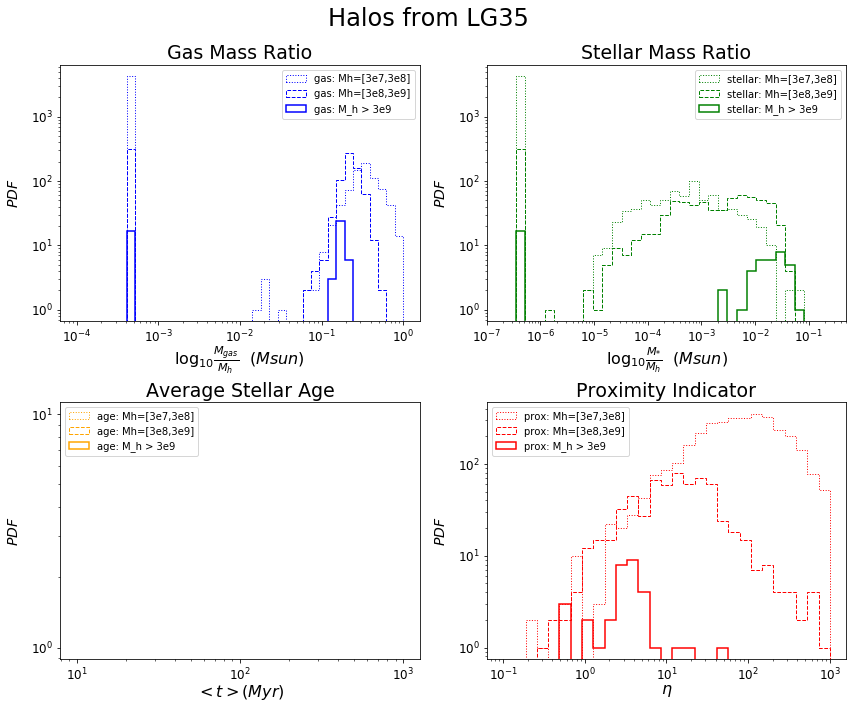

In [104]:
# create subplots
fig1 = plt.figure(figsize = (12,10))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

# plot titles
figtitle = "Halos from LG35"
gastitle = "Gas Mass Ratio"
stellartitle = "Stellar Mass Ratio"
agetitle = "Average Stellar Age"
proxtitle = "Proximity Indicator"

# plot various lists
ratiolists = [ratiolist1, ratiolist2]
ax1.hist(new_ratiolist11, gasbins, ec = 'blue', lw = 1, label = 'gas: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax1.hist(new_ratiolist12, gasbins, ec = 'blue', lw = 1, label = 'gas: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax1.hist(new_ratiolist13, gasbins, ec = 'blue', lw = 1.5, label = 'gas: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax2.hist(new_ratiolist21, stelbins, ec = 'green', lw = 1, label = 'stellar: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax2.hist(new_ratiolist22, stelbins, ec = 'green', lw = 1, label = 'stellar: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax2.hist(new_ratiolist23, stelbins, ec = 'green', lw = 1.5, label = 'stellar: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax3.hist(ave_agelist1, agebins, ec = 'orange', lw = 1, label = 'age: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax3.hist(ave_agelist2, agebins, ec = 'orange', lw = 1, label = 'age: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax3.hist(ave_agelist3, agebins, ec = 'orange', lw = 1.5, label = 'age: M_h > 3e9', linestyle = "-", histtype='step', fill = False)
ax4.hist(proxlist1, proxbins, ec = 'red', lw = 1, label = 'prox: Mh=[3e7,3e8]', linestyle = ":", histtype='step', fill = False)
ax4.hist(proxlist2, proxbins, ec = 'red', lw = 1, label = 'prox: Mh=[3e8,3e9]', linestyle = "--",histtype='step', fill = False)
ax4.hist(proxlist3, proxbins, ec = 'red', lw = 1.5, label = 'prox: M_h > 3e9', linestyle = "-", histtype='step', fill = False)

# set title
plt.suptitle(figtitle, fontsize = 24)
ax1.set_title(gastitle, size = 19)
ax2.set_title(stellartitle, size = 19)
ax3.set_title(agetitle, size = 19)
ax4.set_title(proxtitle, size = 19)
#ax1.axis([1e-4, 10**1.5, 0, 700])

# create axis labels
gaslab = r"$\log_{10}\frac{M_{gas}}{M_h}$  $(Msun)$"
stellab = r"$\log_{10}\frac{M_{*}}{M_h}$  $(Msun)$"
agelab = r"$<t> (Myr)$"
proxlab = r"$\eta$"
ylab = "$PDF$"
ax1.set_xlabel(gaslab, size = 16, labelpad= 0)
ax2.set_xlabel(stellab, size = 16, labelpad= 0)
ax3.set_xlabel(agelab, size = 16, labelpad= 0)
ax4.set_xlabel(proxlab, size = 16, labelpad= 0)
ax1.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax2.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax3.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)
ax4.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)

# create axis ticks 
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(axis='x', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.tick_params(axis='x', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)


# add labels for each plot
# annotation1 = 'using .sum'
# annotation2 = 'using particle mask'
# ax1.text(start, 20, annotation1, size = 12)
# ax2.text(start, 30, annotation2, size = 12)

# set axis limits
ax2.set_xlim([1e-7, 0.5])

# add legend
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper left')
ax4.legend(loc = 'upper left')

# adjust spacing and show
plt.tight_layout()
fig1.subplots_adjust(top=0.9)
plt.show()

#plt.savefig('./LG4_2048_40pc/rd0070/massratios.png', dpi = 300)

In [105]:
new_logratio21 = np.log([value for value in new_ratiolist21 if value > 0]) / log(10)
new_logratio22 = np.log([value for value in new_ratiolist22 if value > 0]) / log(10)
new_logratio23 = np.log([value for value in new_ratiolist23 if value > 0]) / log(10)

plot_logratio23 = 30**(new_logratio23 + 2.5)

In [67]:
plot_logratio23

array([  6.50154652e+01,   7.67006419e+00,   1.39945892e+02,
         9.02103316e+01,   7.90991939e+00,   8.78569234e+00,
         4.45692021e+01,   6.60731960e-01,   1.52549345e+01,
         8.80154246e-01,   7.50145647e+01,   6.09245227e+01,
         2.19455353e+01,   1.08088015e+02,   4.83284348e+01,
         5.88290184e+01,   1.47125323e+02,   1.09969077e+01,
         6.61954723e+00,   2.85551696e+02,   1.24529495e+02,
         1.04491376e+02,   3.62774611e+02,   1.03949489e+02,
         1.36386299e+02,   4.16685659e+01,   4.18832432e+01,
         1.08438582e+02,   1.91294308e+01,   1.97476824e+02,
         1.35847171e+02,   2.01867176e+01,   9.10934673e+00,
         2.09541719e+01,   1.12050032e+01,   4.01844324e+01,
         2.97002651e+01,   2.43690760e-68,   8.09220054e-68,
         2.31405092e+01,   3.16909448e+01,   3.19454608e+01,
         6.88763548e+01,   6.46793721e+01,   1.23188975e+02,
         7.34959570e+01,   2.91135153e+01,   2.92456179e+02,
         1.07084666e+01,

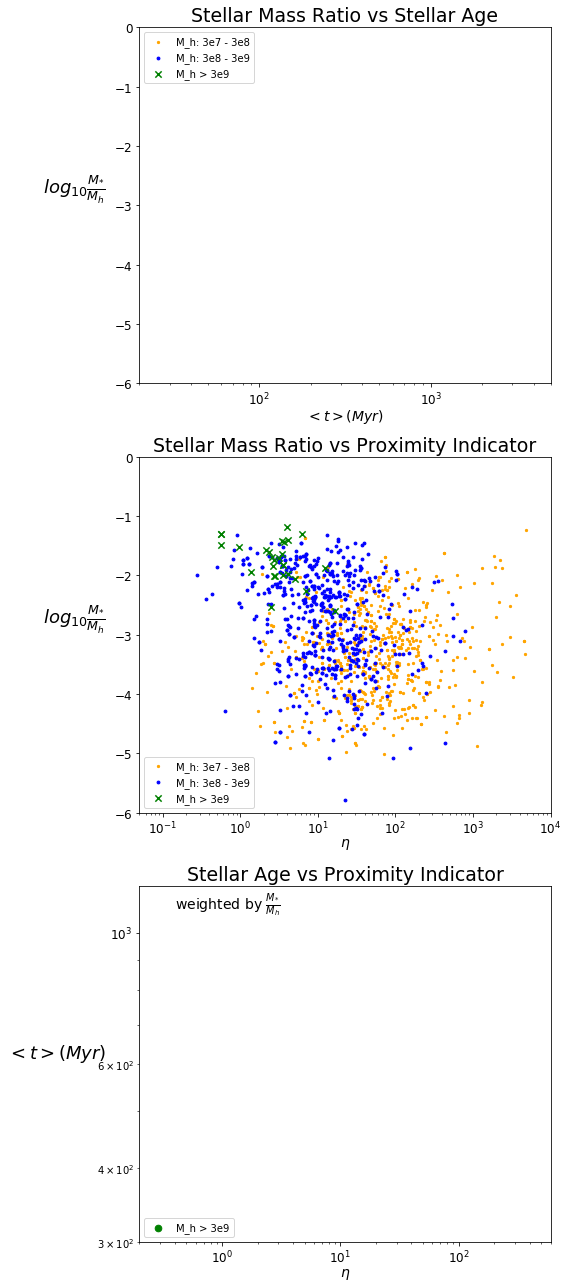

In [106]:
# specify figure size
fig2 = plt.figure(figsize=(8,18))
ax1 = fig2.add_subplot(311)
ax2 = fig2.add_subplot(312)
ax3 = fig2.add_subplot(313)

# create subplot titles
agetitle = "Stellar Mass Ratio vs Stellar Age"
proxtitle = "Stellar Mass Ratio vs Proximity Indicator"
ageproxtitle = "Stellar Age vs Proximity Indicator"

# # --determine line of best fit
# # reduce range of values to fit line
# bin_edges_fit1 = bin_edges1[8:-10]
# bin_edges_fit2 = bin_edges2[16:-4]
# log_density_fit1 = log_density1[7:-10]
# log_density_fit2 = log_density2[15:-4]
# # determine line
# par1 = np.polyfit(bin_edges_fit1, log_density_fit1, 1, full=True)
# par2 = np.polyfit(bin_edges_fit2, log_density_fit2, 1, full=True)
# slope1, intercept1 = par1[0][0], par1[0][1]
# slope2, intercept2 = par2[0][0], par2[0][1]

# plot data 
ax1.scatter(ave_agelist1, new_logratio21, c = 'orange', s = 5, label = 'M_h: 3e7 - 3e8')
ax1.scatter(ave_agelist2, new_logratio22, c = 'blue', s = 8, label = 'M_h: 3e8 - 3e9')
ax1.scatter(ave_agelist3, new_logratio23, c = 'green', s = 40, label = 'M_h > 3e9', marker = 'x')
ax2.scatter(proxlist1, new_logratio21, c = 'orange', s = 5, label = 'M_h: 3e7 - 3e8')
ax2.scatter(proxlist2, new_logratio22, c = 'blue', s = 8, label = 'M_h: 3e8 - 3e9')
ax2.scatter(proxlist3, new_logratio23, c = 'green', s = 40, label = 'M_h > 3e9', marker = 'x')
ax3.scatter(proxlist3, ave_agelist3, c = 'green', s = plot_logratio23, cmap='binary', label = 'M_h > 3e9')
# ax2.plot(bin_edges_red1, slope1 * bin_edges_red1 + intercept1, color = 'red')
# ax2.plot(bin_edges_red2, slope2 * bin_edges_red2 + intercept2, color = 'red')
ax1.set_title(agetitle, size = 19)
ax2.set_title(proxtitle, size = 19)
ax3.set_title(ageproxtitle, size = 19)

# create axis labels
agelab = "$<t> (Myr)$"
proxlab = r"$\eta$"
ylab = r"$log_{10}\frac{M_{*}}{M_h}$"
ax1.set_xlabel(agelab, size = 14, labelpad= 0)
ax1.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 40)
ax2.set_xlabel(proxlab, size = 14, labelpad= 0)
ax2.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 40)
ax3.set_xlabel(proxlab, size = 14, labelpad= 0)
ax3.set_ylabel(agelab, rotation = 0, size = 18, labelpad= 40)

# create axis ticks and set y lim
ax1.set_xscale('log')
ax1.set_xlim([20, 5e3])
ax1.set_ylim([-6, 0])
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.set_xscale('log')
ax2.set_xlim([5e-2, 1e4])
ax2.set_ylim([-6, 0])
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([2e-1, 6e2])
ax3.set_ylim([3e2, 1.2e3])
ax3.tick_params(axis='x', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)

# add annotation
annotation = r"weighted by $\frac{M_{*}}{M_h}$"
ax3.text(4e-1, 1.1e3, annotation, size = 14)

# add legend
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'lower left')
ax3.legend(loc = 'lower left')

# adjust spacing and show
plt.tight_layout()
plt.show()

In [124]:
# find log arrays for ratio lists
log_ratio1 = np.log(ratiolist1) / log(10)
log_ratio2 = np.log([value for value in ratiolist2 if value > 0]) / log(10)

# find histogram parameters
density1, bin_edges1 = np.histogram(log_ratio1, bins= np.linspace(-3.5, 0.4, 39))
density2, bin_edges2 = np.histogram(log_ratio2, bins= np.linspace(-2.2, 1.1, 33))


log_density1 = np.log(density1) / log(10)
log_density2 = np.log(density2) / log(10)

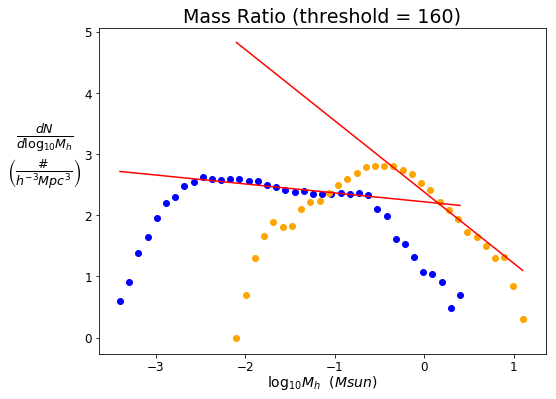

In [161]:
# specify figure size
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)

# --determine line of best fit
# reduce range of values to fit line
bin_edges_fit1 = bin_edges1[8:-10]
bin_edges_fit2 = bin_edges2[16:-4]
log_density_fit1 = log_density1[7:-10]
log_density_fit2 = log_density2[15:-4]
# determine line
par1 = np.polyfit(bin_edges_fit1, log_density_fit1, 1, full=True)
par2 = np.polyfit(bin_edges_fit2, log_density_fit2, 1, full=True)
slope1, intercept1 = par1[0][0], par1[0][1]
slope2, intercept2 = par2[0][0], par2[0][1]

# plot data and line
bin_edges_red1 = bin_edges1[1:]
bin_edges_red2 = bin_edges2[1:]
ax2.scatter(bin_edges_red1, log_density1, color = 'blue')
ax2.scatter(bin_edges_red2, log_density2, color = 'orange')
ax2.plot(bin_edges_red1, slope1 * bin_edges_red1 + intercept1, color = 'red')
ax2.plot(bin_edges_red2, slope2 * bin_edges_red2 + intercept2, color = 'red')
ax2.set_title("Mass Ratio (threshold = 160)", size = 19)

# create axis labels
xlab = "$\log_{10}M_h}$  $(Msun)$"
ylab = r"$\frac{dN}{d\log_{10}M_h}$"+"\n"+r"$\left(\frac{\#}{h^{-3}Mpc^3}\right)$"
ax2.set_xlabel(xlab, size = 14, labelpad= 0)
ax2.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 40)

# create axis ticks 
ax2.set_yscale('linear')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

# add slope and intercept
# annotation = "$a = {:1.3f}$ \n$b = {:1.3f}$".format(slope, intercept)
# plt.text(9.5, 1.5, annotation, size = 12)

#show and save
plt.show()

27


27